In [ ]:
#Mounting the data folder.
#The datafolder download link : https://drive.google.com/drive/folders/1xUtEFYmeofJo-W0qYokaJjOUHukE7bzB?usp=sharing
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Importing all the libraries

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from PIL import Image

In [ ]:
#Searching for GPU. Make sure your Runtime is GPU.

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
  torch.cuda.device_count()
  torch.cuda.get_device_name(0)
  !nvidia-smi
else:
  device = torch.device("cpu")

GPU
Wed Jan 12 20:18:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    35W / 250W |   1253MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+---

In [ ]:
# Applying Transforms to the Data

image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size = 400, scale=(0.8, 1.0)), #size=256
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 300), #size=224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size = 400), #size=256
        transforms.CenterCrop(size = 300), #size=224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size = 400), #size=256
        transforms.CenterCrop(size = 300), #size=224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
#Loading the trained model.

trained_model = torch.load("/content/gdrive/MyDrive/c1/c1_AlexNet_30.pt")

In [ ]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/gdrive/MyDrive/c1'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'val')

# Batch size
bs = 8

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['val'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['val'], batch_size=bs, shuffle=True)

2
{0: 'les', 1: 'nv'}


In [ ]:
#Reading the index for test data.

test_data = os.path.join(dataset, 'test')
filesArray_unsorted = [x for x in os.listdir(test_data) if os.path.isfile(os.path.join(test_data,x))]
filesArray = sorted(filesArray_unsorted)

In [ ]:
#Creating empty Data frame for storing the prediction result.

df = pd.DataFrame({
                   "name":[],
                   "class":[]
                   })

In [ ]:
#The predict function.

def predict(model, test_image_name):
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 300, 300).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor).cuda()
        _, preds = torch.max(out.data, 1)
        return preds

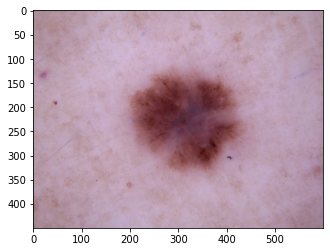

In [ ]:
#Predicting (Image by Image) and creating the result csv

for file_name in filesArray:
  image_name = os.path.join(test_data, file_name)

  label = predict(trained_model, image_name).item()
  
  #Our automated labeling model set les = 0 and nv = 1. But, for submission, we have les = 1 and nv = 0.
  #So here we are just reversing the labels.
  if label == 0:
    new_label = 1
  else:
    new_label = 0
  
  df = df.append({
                    "name": file_name,
                    "class": new_label
                   },ignore_index = True)
#Saving the dataframe as a CSV file.
df.to_csv('/content/gdrive/MyDrive/TEST_Challenge_1_result(with updated labels).csv', index = False)              